## Import stuff

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pickle
import os

from PIL import Image

In [2]:
from mysticetus import model_driven_reco
from mysticetus import Measurement
from mysticetus import plotting
from mysticetus import file_loading
from mysticetus import basinhopping_functionality

from config_illumination import pl as obj_pl
from config_illumination import make_objective
from config_illumination import p2params
from config_illumination import params2p
from config_illumination import ResultProcessingPipeline

## Load real data

In [3]:
m_list      = []
measId      = 0

In [4]:
%cd /home/mz6084/fowgas/data/hibef/beamtimes/LCLS/1610_lcls_mec_ln04/evaluation/gratings_Jena/gratings_Jena/

# load
temp_meas   = file_loading.load_measurement('run_139_frame_1_preshot_300nm_-2000fs.tif')
temp_mask   = file_loading.load_mask(       'run_139_frame_1_preshot_300nm_-2000fs_mask.tif')
# y crop
temp_meas   = temp_meas[:, 863:871]
temp_mask   = temp_mask[:, 863:871]
# x align
meas        = np.zeros(shape=temp_meas.shape)
mask        = np.zeros(shape=temp_mask.shape)
meas[142:2048]\
            = temp_meas[0:2048-142]
mask[142:2048]\
            = temp_mask[0:2048-142]
# swap
mask        = mask.T
meas        = meas.T
# set up definition domain
x           = np.arange(model_driven_reco.binary_ceil(meas.shape[1]))
y           = np.arange(model_driven_reco.binary_ceil(meas.shape[0]))
xx, yy      = np.meshgrid(x, y)
domain      = {'xx':xx, 'yy':yy}
assert domain['xx'].shape == meas.shape

m           = Measurement.Measurement(domain, meas)
m.mask      = mask
m.measId    = measId
m_list.append(m)
measId      += 1

/home/mz6084/fowgas/data/hibef/beamtimes/LCLS/1610_lcls_mec_ln04/evaluation/gratings_Jena/gratings_Jena


## Show data

/home/mz6084/fowgas/packages/mysticetus/plotting.py:36: RuntimeWarning: divide by zero encountered in log
  im2             = np.log(meas)
/home/mz6084/fowgas/packages/mysticetus/plotting.py:36: RuntimeWarning: invalid value encountered in log
  im2             = np.log(meas)
/home/mz6084/fowgas/packages/mysticetus/plotting.py:49: RuntimeWarning: divide by zero encountered in log
  im4         = mask*np.log(meas)
/home/mz6084/fowgas/packages/mysticetus/plotting.py:49: RuntimeWarning: invalid value encountered in log
  im4         = mask*np.log(meas)
/home/mz6084/fowgas/packages/mysticetus/plotting.py:49: RuntimeWarning: invalid value encountered in multiply
  im4         = mask*np.log(meas)


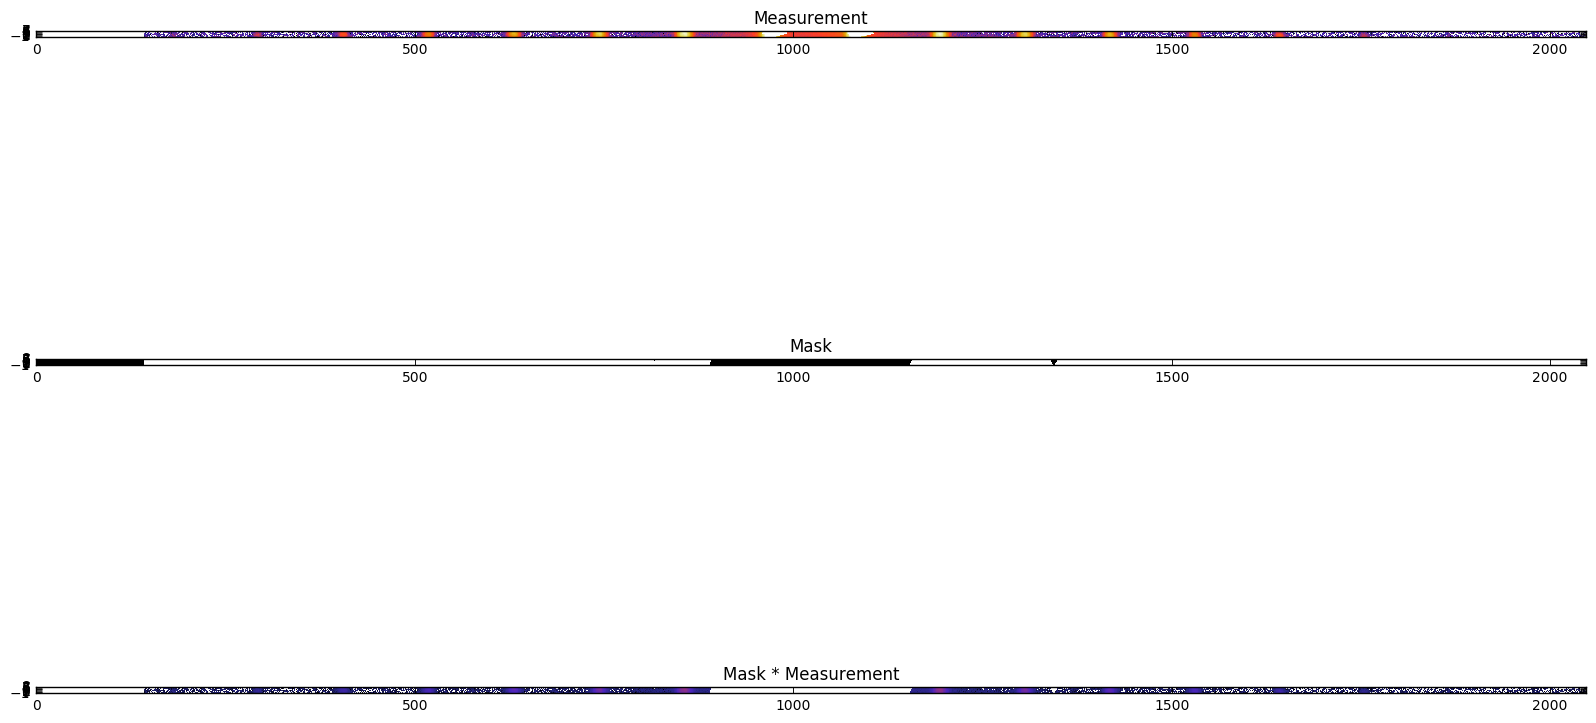

In [5]:
# Plot
fig     = plt.figure(figsize=(20, len(m_list)*3*4))

icase   = 0
for m in m_list:
    plotting.show_measurement_data(m, len(m_list), icase, fig)
    icase   += 1

## Draw start parametersets

In [6]:
# Define number of start paramsets to draw
nstart = 1

# Draw
#start_params_list = draw_paramsets(nstart, ensemble=random_start_paramset, **domain_scales(x))
start_params_list = [{'pitch': 36.45, 'sigma': 0.36248428813714756, 'fsize': 18.225, 'sill': 1000},]

for start_params in start_params_list:
    print(start_params)

{'sigma': 0.36248428813714756, 'pitch': 36.45, 'fsize': 18.225, 'sill': 1000}


## Reconstruct from 2D measurement data

In [7]:
%%prun -rq

# Define number of basinhopping steps
niter = 5

# Initialize accept_test - enforces bounds on parameters during basinhopping
#parambounds = ParamBounds([np.max(xx), np.max(xx), np.max(xx)], [0., 0., 0.])
accept_test = basinhopping_functionality.CombinedTest([np.max(xx), np.max(xx), np.max(xx), 10*np.max(xx)], [0, 32, 16, 100], [2, 40, 20, 20000])
hard_test   = basinhopping_functionality.HardTest()
scaled_disp = basinhopping_functionality.ScaledAxesDisplacement([0.2, 0.5, 0.25, 512])
take_step   = basinhopping_functionality.TestedDisplacement(scaled_disp, hard_test)

# Create PSF
psf = model_driven_reco.create_psf(xx, yy, 2.8)

class RawData:
    pass

results = []
for m in m_list:
    startId = 0
    for start_params in start_params_list:
        results.append(RawData())
        results[-1].startId      = startId
        results[-1].m            = m
        results[-1].start_params = start_params
        
        # Make objective function
        consts     = {'domain':m.domain, 'psf':psf, 'meas':m.meas, 'mask':m.mask}
        obj        = make_objective(obj_pl, consts, p_wrap=p2params)
        
        # Set up minimizer
        min_kwargs = {'method' : 'BFGS'}

        # Run reconstruction
        callback   = basinhopping_functionality.CallbackSaveAll()
        callback.x       .append(params2p(start_params))
        callback.f       .append(obj(params2p(start_params)))
        callback.accepted.append(True)
        ret        = model_driven_reco.basinhopping(
                                obj, params2p(start_params),
                                T                = 10,
                                stepsize         = 5,
                                take_step        = take_step,
                                minimizer_kwargs = min_kwargs,
                                niter            = niter,
                                callback         = callback,
                                accept_test      = accept_test)

        results[-1].xs = callback.get_x()
        results[-1].fs = callback.get_f()
        results[-1].accs = callback.get_accepted()
        results[-1].bh_return = ret
        startId += 1

In [8]:
timing_results = _
timing_results.print_stats(15)

         17583 function calls (17408 primitive calls) in 0.894 seconds

   Ordered by: internal time
   List reduced from 182 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       61    0.144    0.002    0.144    0.002 {built-in method numpy.fft.fftpack_lite.rfftb}
      183    0.125    0.001    0.125    0.001 grating2.py:22(fct_edge)
      122    0.088    0.001    0.088    0.001 {built-in method numpy.fft.fftpack_lite.rfftf}
       61    0.085    0.001    0.096    0.002 basic.py:487(_raw_fftnd)
      122    0.068    0.001    0.068    0.001 {built-in method numpy.fft.fftpack_lite.cfftf}
       61    0.057    0.001    0.070    0.001 model_driven_reco.py:438(create_illumination)
       61    0.036    0.001    0.145    0.002 model_driven_reco.py:33(meas_model_basic_far_field_intensity_2D)
       61    0.035    0.001    0.188    0.003 grating2.py:34(fct_grat)
       61    0.029    0.000    0.029    0.000 {built-in method numpy.fft.fft

## Show 2D results

min_val:  -8.78895495217e-06
max_val:  0.0118905409649


/home/mz6084/fowgas/packages/mysticetus/plotting.py:123: RuntimeWarning: invalid value encountered in log
  im3             = np.log(normed_opt_meas)
/home/mz6084/fowgas/packages/mysticetus/plotting.py:131: RuntimeWarning: divide by zero encountered in log
  im4             = np.log(normed_meas)
/home/mz6084/fowgas/packages/mysticetus/plotting.py:131: RuntimeWarning: invalid value encountered in log
  im4             = np.log(normed_meas)


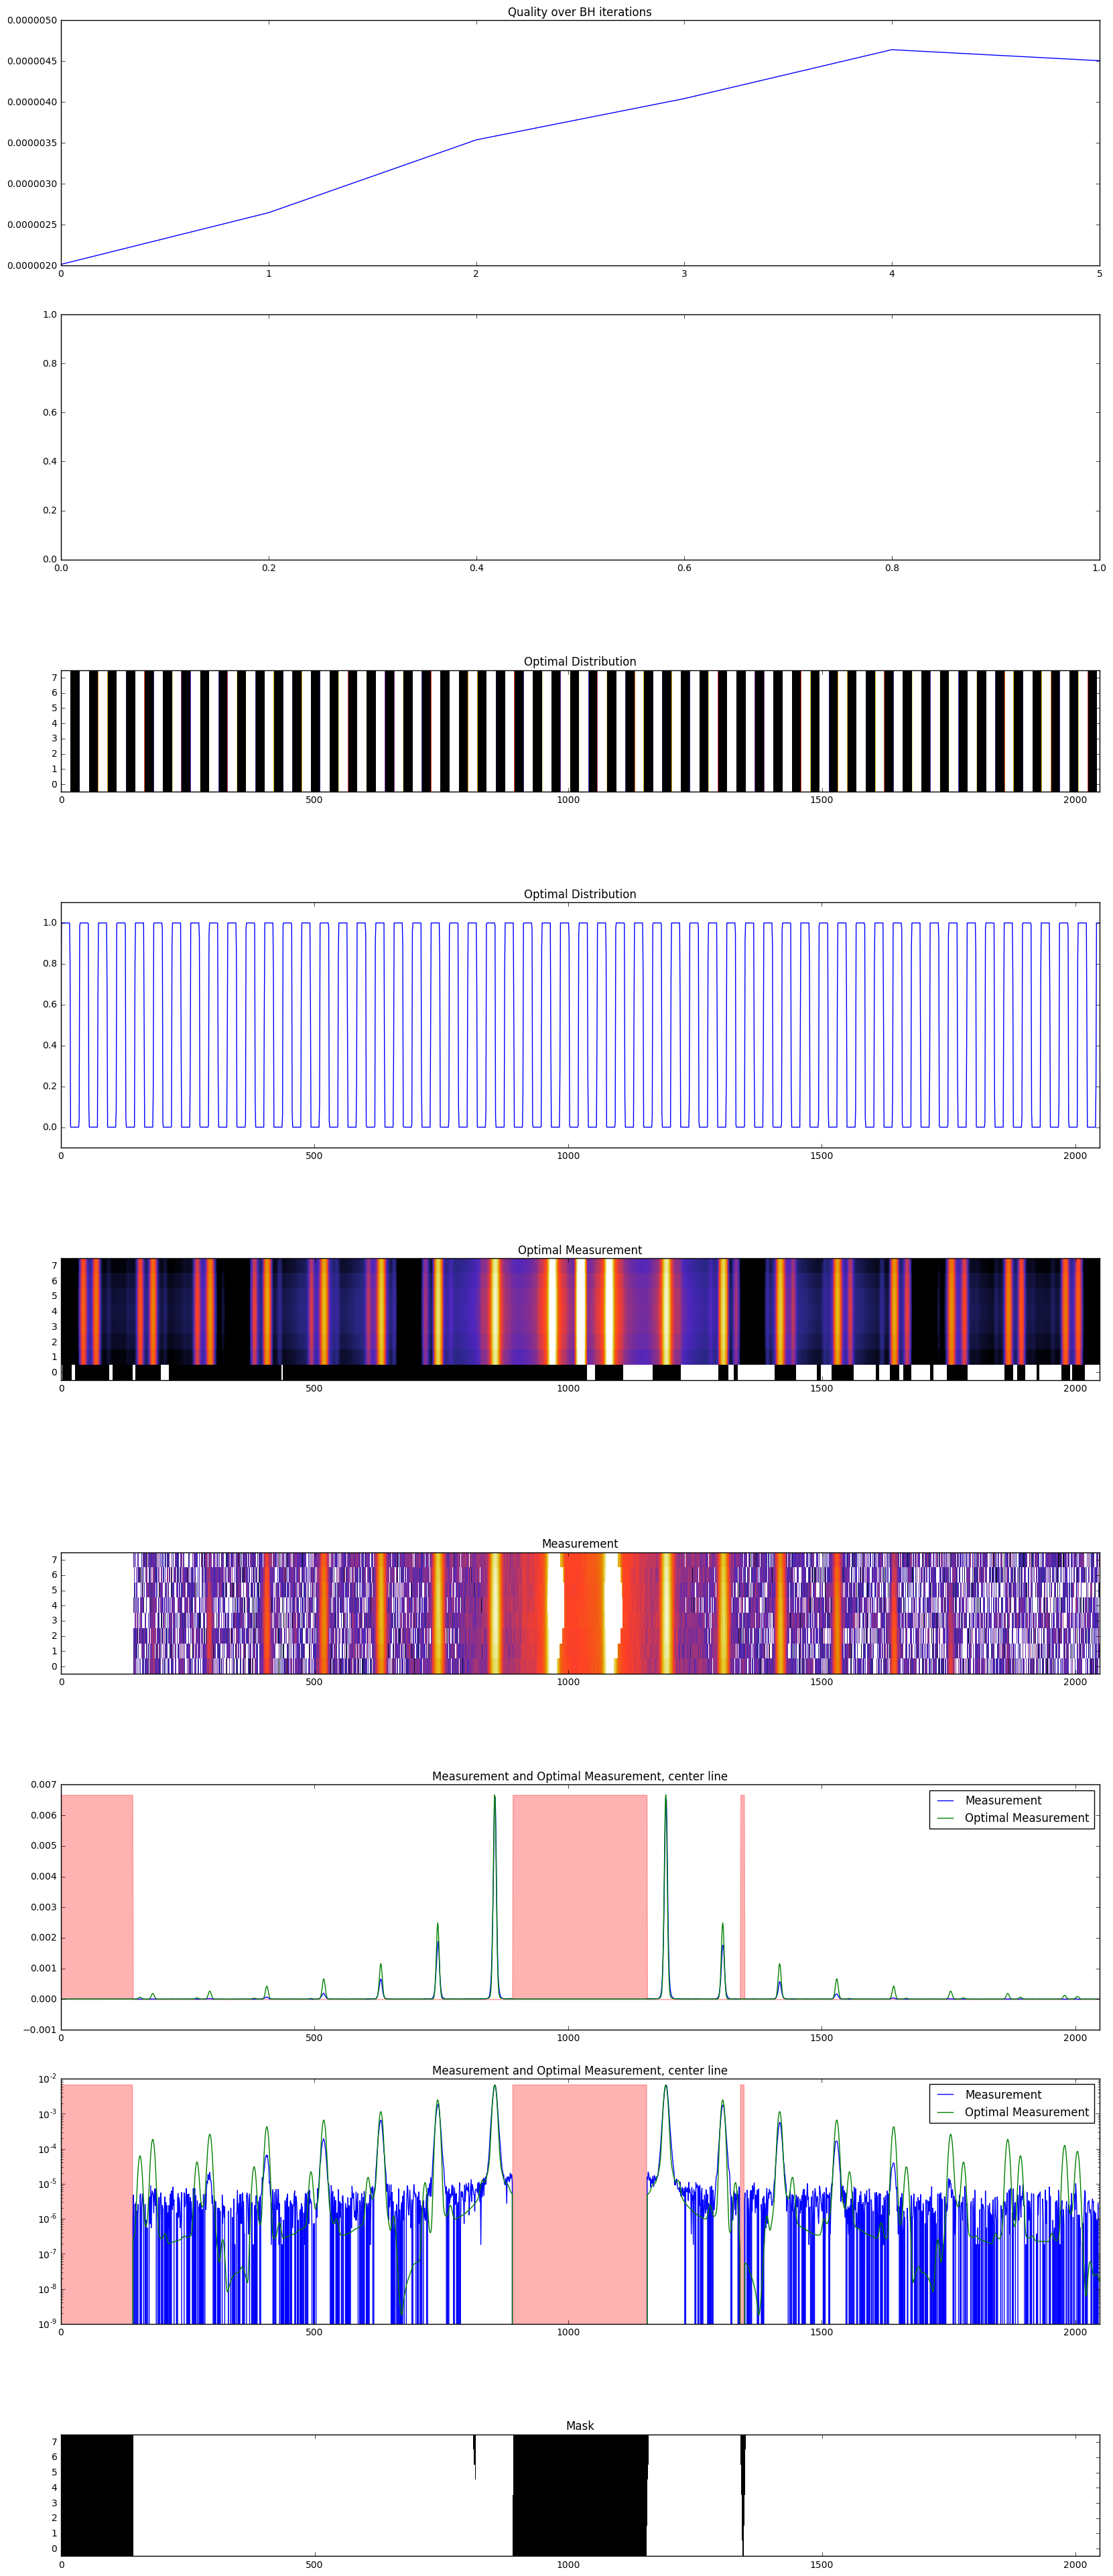

In [9]:
rs = plotting.ResultShow(len(results), figsize=(20, 50), aspect=30)    
for result in results:
    consts = {'domain':{'xx':xx, 'yy':yy}, 'psf':psf, 'meas':result.m.meas}
    pr = model_driven_reco.ProcessResult(ResultProcessingPipeline(), consts)
    rs(pr(result))